In [1]:
from zipfile import ZipFile
from pathlib import Path
import geopandas as gpd
import fiona
import pandas as pd
import shutil
from itertools import starmap
from rasterio.crs import CRS

fiona.drvsupport.supported_drivers['kml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['KML'] = 'rw' # enable KML support which is disabled by default

In [2]:
kmzs = list(Path('.').glob('kmz/*.kmz'))
kmzs

[PosixPath('kmz/track_161_Aleutians.kmz'),
 PosixPath('kmz/track_088_Aleutians.kmz'),
 PosixPath('kmz/track_095_Aleutians.kmz'),
 PosixPath('kmz/track_015_Aleutians.kmz'),
 PosixPath('kmz/track_168_Aleutians.kmz'),
 PosixPath('kmz/track_066_Aleutians.kmz'),
 PosixPath('kmz/track_124_Aleutians.kmz'),
 PosixPath('kmz/track_073_Aleutians.kmz'),
 PosixPath('kmz/track_059_Aleutians.kmz'),
 PosixPath('kmz/track_153_Aleutians.kmz'),
 PosixPath('kmz/track_044_Aleutians.kmz'),
 PosixPath('kmz/track_117_Aleutians.kmz'),
 PosixPath('kmz/track_037_Aleutians.kmz')]

In [3]:
def read_one(kmz_path, **kwargs):
    kmz_zip = ZipFile(kmz_path, 'r')
    temp_dir = Path(f'tmp_{kmz_path.stem}')
    temp_dir.mkdir(exist_ok=True)
    kml_path = kmz_zip.extract('doc.kml', temp_dir)
    df = gpd.read_file(kml_path)

    df = gpd.GeoDataFrame(geometry=[df.geometry.unary_union],
                          crs=CRS.from_epsg(4326))
    n = len(kwargs['min_days_backward']) - 1
    if n:
        df = df.append([df]*n).reset_index(drop=True)
    
    for key in list(kwargs):
        df[key] = kwargs[key]
        
    tokens = str(kmz_path.stem).split('_')
    df['aoi_name'] = tokens[-1]
    df['path_number'] = int(tokens[1])
    
    columns = ['aoi_name','path_number'] + list(kwargs.keys()) + ['geometry']
    df = df[columns]
    shutil.rmtree(temp_dir)
    return df

In [4]:
kwargs = {'min_days_backward': [364, 0],
          'month_range_lower': 6,
          'month_range_upper': 10,
          'num_neighbors_ref': 3}

In [5]:
read_one_p = lambda path: read_one(path, **kwargs)
dfs = list(map(read_one_p, kmzs))
dfs[0]

/Users/cmarshak/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,aoi_name,path_number,min_days_backward,month_range_lower,month_range_upper,num_neighbors_ref,geometry
0,Aleutians,161,364,6,10,3,"POLYGON Z ((-173.04266 52.61615 0.00000, -176...."
1,Aleutians,161,0,6,10,3,"POLYGON Z ((-173.04266 52.61615 0.00000, -176...."


<AxesSubplot:>

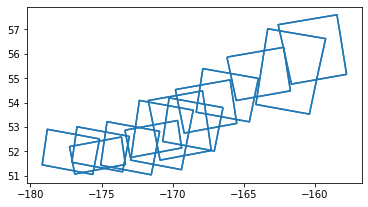

In [6]:
df = pd.concat(dfs, axis=0)
df.exterior.plot()

In [7]:
def write_one(df):
    out_dir = Path('out')
    out_dir.mkdir(exist_ok=True)
    path_number = df.path_number.tolist()[0]
    aoi_name = df.aoi_name[0]
    out_path = out_dir/f'{aoi_name}_pathNumber{path_number}.geojson'
    df.to_file(out_path, driver='GeoJSON')
    return out_path

In [8]:
list(map(write_one, dfs))

[PosixPath('out/Aleutians_pathNumber161.geojson'),
 PosixPath('out/Aleutians_pathNumber88.geojson'),
 PosixPath('out/Aleutians_pathNumber95.geojson'),
 PosixPath('out/Aleutians_pathNumber15.geojson'),
 PosixPath('out/Aleutians_pathNumber168.geojson'),
 PosixPath('out/Aleutians_pathNumber66.geojson'),
 PosixPath('out/Aleutians_pathNumber124.geojson'),
 PosixPath('out/Aleutians_pathNumber73.geojson'),
 PosixPath('out/Aleutians_pathNumber59.geojson'),
 PosixPath('out/Aleutians_pathNumber153.geojson'),
 PosixPath('out/Aleutians_pathNumber44.geojson'),
 PosixPath('out/Aleutians_pathNumber117.geojson'),
 PosixPath('out/Aleutians_pathNumber37.geojson')]

In [9]:
dfs[0].path_number[0]
dfs[0].aoi_name[0]

'Aleutians'